In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os
import re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from sklearn.preprocessing import minmax_scale
import IPython.display as ipd

plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 16
sns.set_style('darkgrid')
warnings.filterwarnings("ignore")


In [ ]:


directory = '/content/drive/MyDrive/Colab Notebooks/Dataset'
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/torgo_data/data.csv")
data['filename'] = data['filename'].apply(lambda x: os.path.join(directory,x))
data

,is_dysarthria,gender,filename
0,non_dysarthria,female,/content/drive/MyDrive/Colab Notebooks/Dataset...
1,non_dysarthria,female,/content/drive/MyDrive/Colab Notebooks/Dataset...
2,non_dysarthria,female,/content/drive/MyDrive/Colab Notebooks/Dataset...
3,non_dysarthria,female,/content/drive/MyDrive/Colab Notebooks/Dataset...
4,non_dysarthria,female,/content/drive/MyDrive/Colab Notebooks/Dataset...
...,...,...,...
1995,dysarthria,male,/content/drive/MyDrive/Colab Notebooks/Dataset...
1996,dysarthria,male,/content/drive/MyDrive/Colab Notebooks/Dataset...
1997,dysarthria,male,/content/drive/MyDrive/Colab Notebooks/Dataset...
1998,dysarthria,male,/content/drive/MyDrive/Colab Notebooks/Dataset...


In [ ]:
def show_mfccs(audio_path,label,gender):
    plt.figure(figsize=(20, 6))
    plt.title(f'MFCC of Class: {label}, Gender: {gender}')
    x , sr = librosa.load(audio_path)
    mfccs = librosa.feature.mfcc(y=x, sr=sr)
    librosa.display.specshow(mfccs, sr=sr, x_axis='time',cmap='plasma')
    plt.show()

def show_melspectro(audio_path,label,gender):
    plt.figure(figsize=(20, 6))
    plt.title(f'Mel Spectro of Class: {label}, Gender: {gender}')
    x , sr = librosa.load(audio_path)
    melspectro = librosa.feature.melspectrogram(y=x, sr=sr)
    librosa.display.specshow(melspectro, sr=sr, x_axis='time',cmap='plasma')
    plt.show()

In [ ]:
data.sample(frac=1).reset_index(drop=True,inplace=True)
male_dysarthric = data[(data['gender']=='male') & (data['is_dysarthria']=='dysarthria')].sample(1)
female_dysarthric = data[(data['gender']=='female') & (data['is_dysarthria']=='dysarthria')].sample(1)
male_ndysarthric = data[(data['gender']=='male') & (data['is_dysarthria']=='non_dysarthria')].sample(1)
female_ndysarthric = data[(data['gender']=='female') & (data['is_dysarthria']=='non_dysarthria')].sample(1)

In [ ]:
ipd.Audio(male_dysarthric.iloc[0].filename)

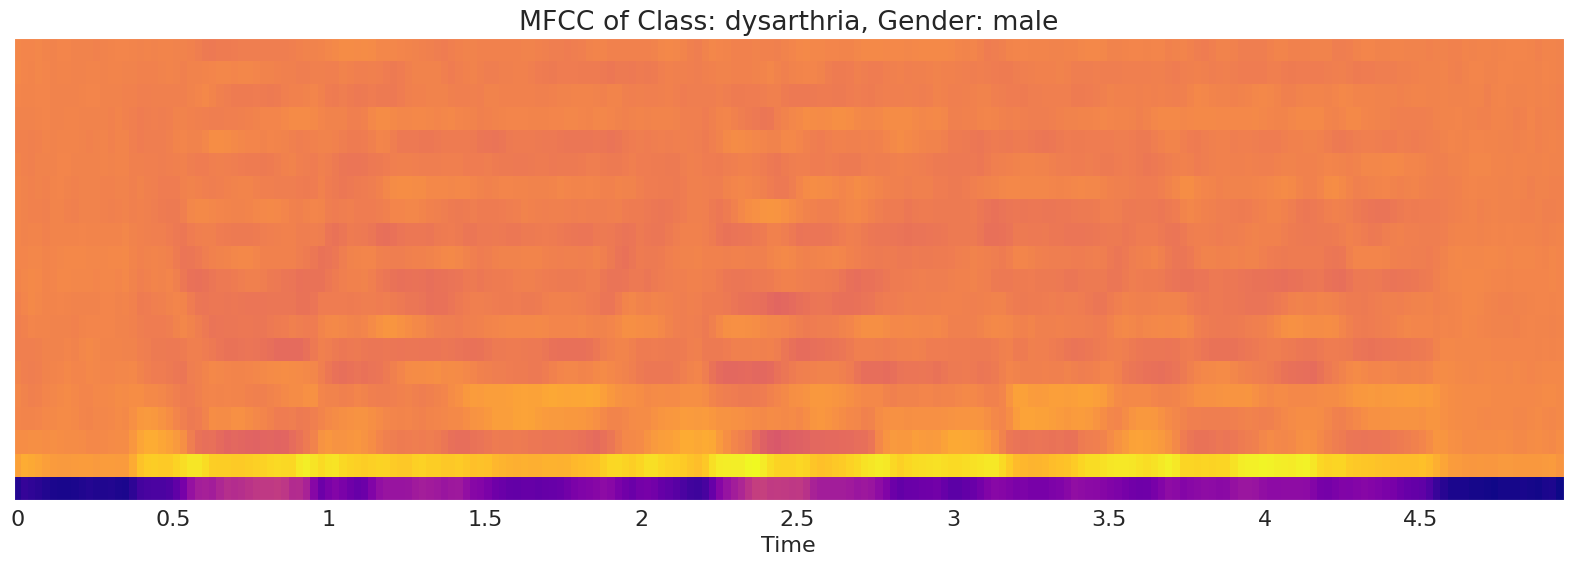

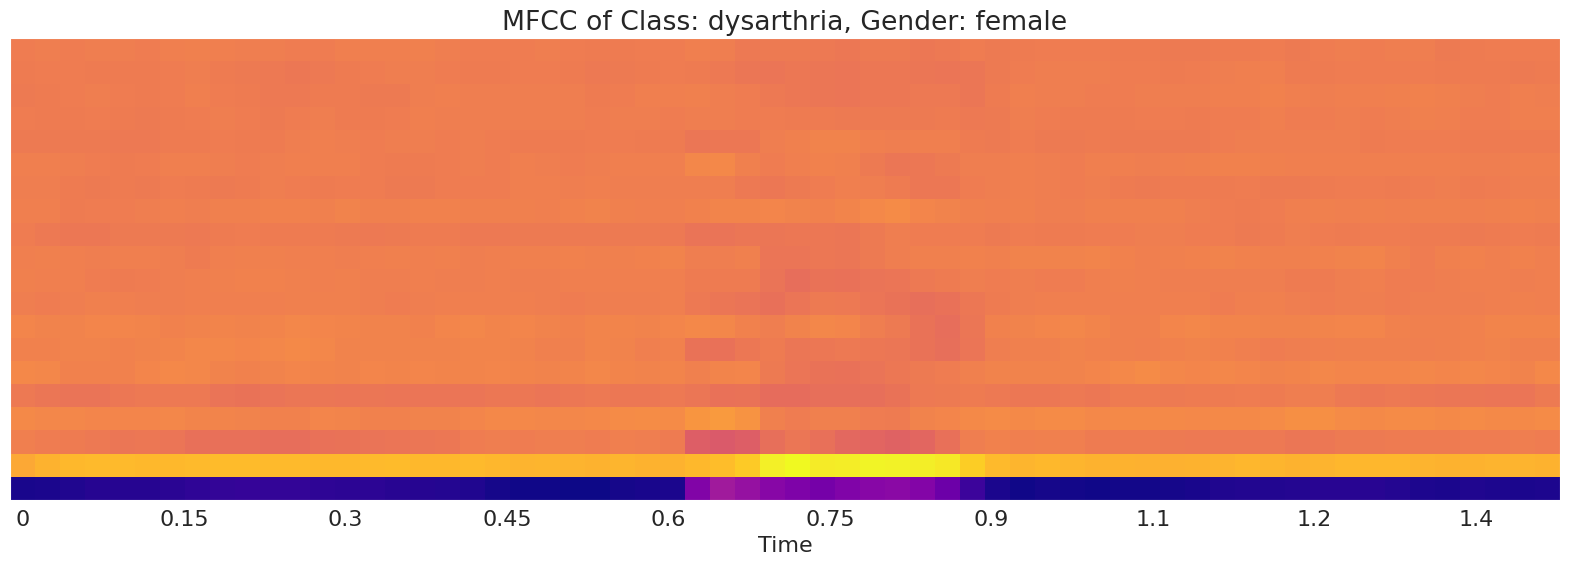

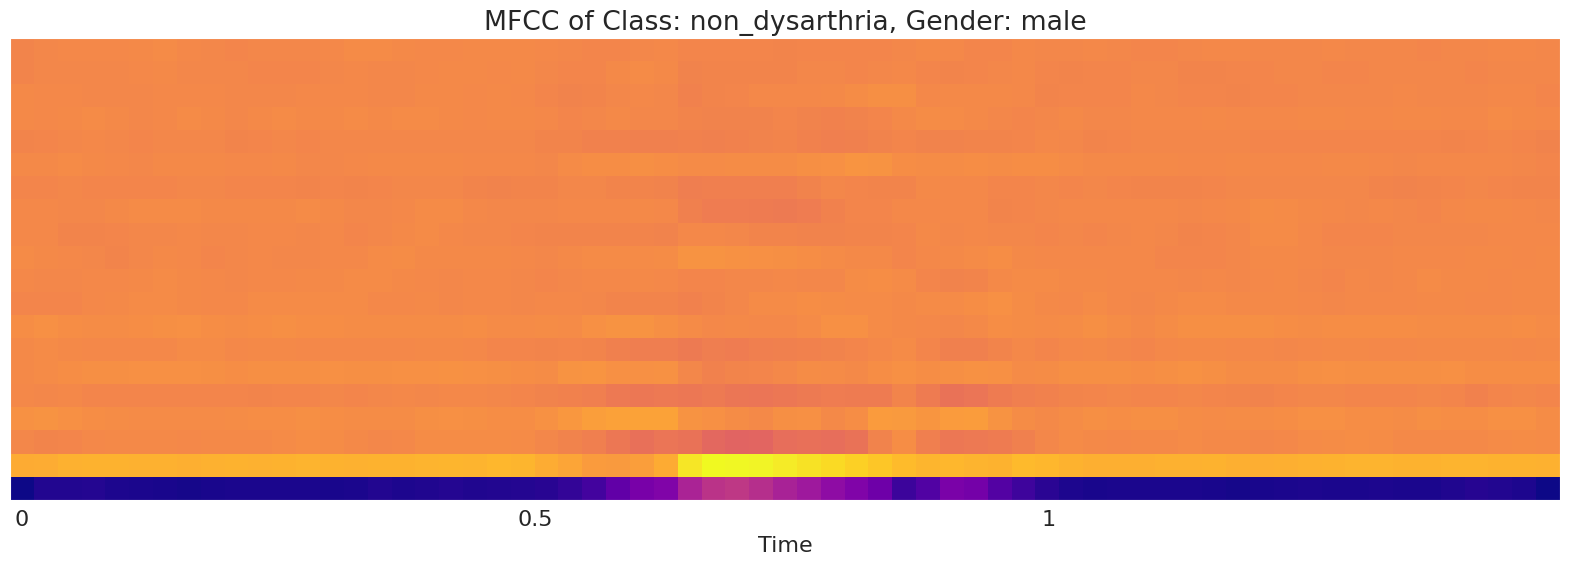

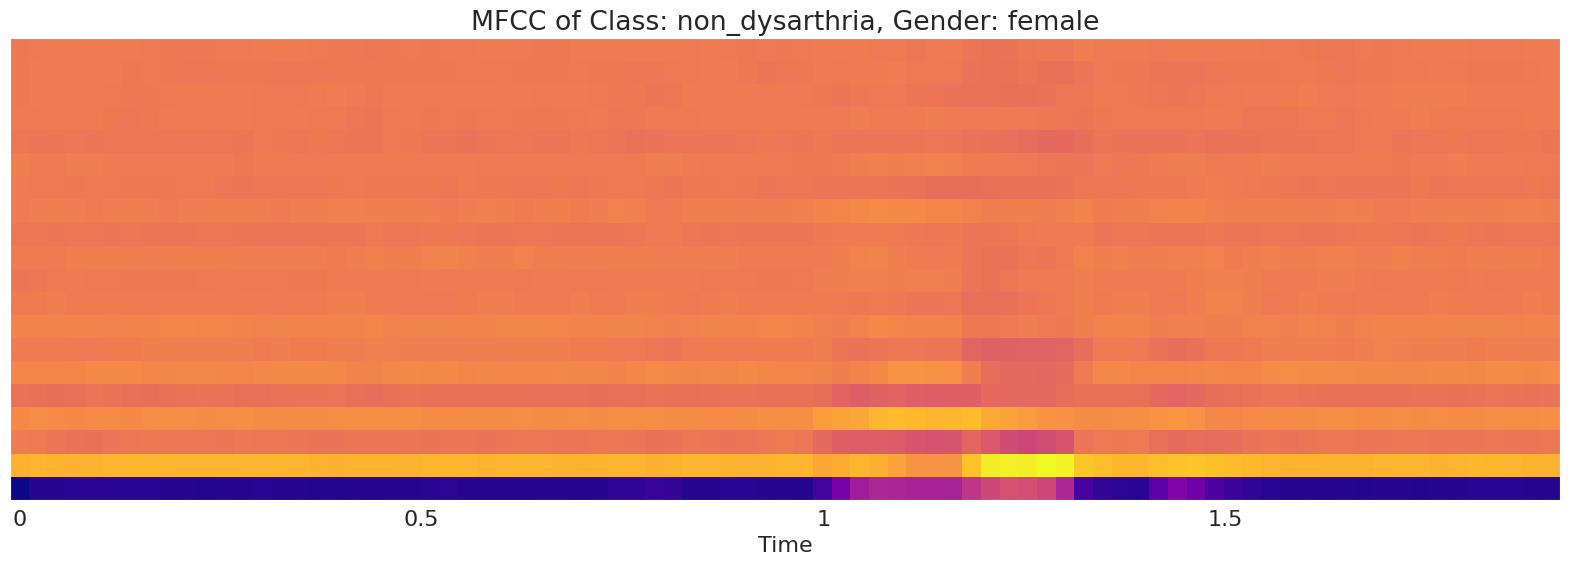

In [ ]:
show_mfccs(male_dysarthric.iloc[0].filename, male_dysarthric.iloc[0].is_dysarthria, male_dysarthric.iloc[0].gender)
show_mfccs(female_dysarthric.iloc[0].filename, female_dysarthric.iloc[0].is_dysarthria, female_dysarthric.iloc[0].gender)
show_mfccs(male_ndysarthric.iloc[0].filename, male_ndysarthric.iloc[0].is_dysarthria, male_ndysarthric.iloc[0].gender)
show_mfccs(female_ndysarthric.iloc[0].filename, female_ndysarthric.iloc[0].is_dysarthria, female_ndysarthric.iloc[0].gender)

In [ ]:
import numpy as np
import pandas as pd
import librosa
from tqdm import tqdm

def feature_extraction(df, frame_duration=0.5, n_mfcc=128):
    features = []
    labels = []

    for i, record in tqdm(df.iterrows(), total=df.shape[0]):
        try:
            # Load the audio file
            x, sr = librosa.load(record['filename'])

            # Calculate the frame length and hop length
            frame_length = int(sr * frame_duration)
            hop_length = frame_length  # Non-overlapping frames

            # Divide the audio into frames and extract MFCCs for each frame
            mfccs = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length)

            # Transpose to make each column a feature vector for a frame
            mfccs = mfccs.T

            # Append the MFCC sequence and the corresponding label
            features.append(mfccs)
            labels.append(record['is_dysarthria'])
        except EOFError:
            pass

    # Create a DataFrame with MFCC features and labels
    dataf = pd.DataFrame({'features': features, 'class': labels})
    return dataf


In [ ]:
data[:10]

,is_dysarthria,gender,filename
0,non_dysarthria,female,/content/drive/MyDrive/Colab Notebooks/Dataset...
1,non_dysarthria,female,/content/drive/MyDrive/Colab Notebooks/Dataset...
2,non_dysarthria,female,/content/drive/MyDrive/Colab Notebooks/Dataset...
3,non_dysarthria,female,/content/drive/MyDrive/Colab Notebooks/Dataset...
4,non_dysarthria,female,/content/drive/MyDrive/Colab Notebooks/Dataset...
5,non_dysarthria,female,/content/drive/MyDrive/Colab Notebooks/Dataset...
6,non_dysarthria,female,/content/drive/MyDrive/Colab Notebooks/Dataset...
7,non_dysarthria,female,/content/drive/MyDrive/Colab Notebooks/Dataset...
8,non_dysarthria,female,/content/drive/MyDrive/Colab Notebooks/Dataset...
9,non_dysarthria,female,/content/drive/MyDrive/Colab Notebooks/Dataset...


In [ ]:
##misc
dataf = feature_extraction(data[:10])

100%|██████████| 10/10 [00:21<00:00,  2.20s/it]


In [ ]:
dataf['features'][0].shape
features = dataf['features'].tolist()
len(features[0][0])

128

In [ ]:
# Prepare the data
dataf = feature_extraction(data)  # Use the modified feature extraction function
features = dataf['features'].tolist()

dataf.loc[dataf['class']=='non_dysarthria','class'] = 0.0
dataf.loc[dataf['class']=='dysarthria','class'] = 1.0
dataf['class'] = dataf['class'].astype(float)

X = dataf.iloc[:,:-1].values
y = dataf.iloc[:,-1]

100%|██████████| 2000/2000 [11:31<00:00,  2.89it/s]


In [ ]:
dataf


,features,class
0,"[[-349.57996, 88.658356, 2.9485917, 42.87787, ...",0.0
1,"[[-365.09973, 106.17833, -10.13237, 44.397133,...",0.0
2,"[[-371.53207, 111.69104, -14.992079, 48.625534...",0.0
3,"[[-350.26144, 90.40643, -4.811821, 36.470028, ...",0.0
4,"[[-360.67914, 106.83412, -15.331825, 53.359856...",0.0
...,...,...
1994,"[[-445.72336, 84.9243, 20.255573, 10.9954815, ...",1.0
1995,"[[-597.95087, 39.568825, 25.441933, 14.252387,...",1.0
1996,"[[-435.56274, 104.44789, 5.581156, 15.847317, ...",1.0
1997,"[[-441.06155, 92.33444, 13.777567, 9.924803, -...",1.0


In [ ]:
#Reusable code for cross validation

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def train_and_evaluate_with_cv(model_name, X, y, n_splits=5, epochs=20, batch_size=32):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    all_precisions, all_recalls, all_f1s, all_accuracies = [], [], [], []

    best_fold_idx = -1
    best_accuracy = 0.0
    best_y_val, best_preds = None, None
    best_history = None

    for fold, (train_idx, val_idx) in enumerate(kf.split(X), start=1):
        print(f"\n=== Fold {fold} ===")
        model = model_name
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        history = model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            verbose=0,
            validation_data=(X_val, y_val)
        )

        preds = model.predict(X_val)
        binary_preds = (preds > 0.5).astype(int)

        precision = precision_score(y_val, binary_preds)
        recall = recall_score(y_val, binary_preds)
        f1 = f1_score(y_val, binary_preds)
        accuracy = accuracy_score(y_val, binary_preds)

        all_precisions.append(precision)
        all_recalls.append(recall)
        all_f1s.append(f1)
        all_accuracies.append(accuracy)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_fold_idx = fold
            best_y_val = y_val
            best_preds = binary_preds
            best_history = history

        print(f"Accuracy:  {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall:    {recall:.4f}")
        print(f"F1-Score:  {f1:.4f}")

    # Confusion matrix for best fold
    cm = confusion_matrix(best_y_val, best_preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Dysarthria', 'Dysarthria'],
                yticklabels=['Non-Dysarthria', 'Dysarthria'])
    plt.title(f'Confusion Matrix - Best Fold {best_fold_idx}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Plot loss and accuracy curves
    if best_history:
        history = best_history.history
        plt.figure(figsize=(12, 5))

        # Loss curve
        plt.subplot(1, 2, 1)
        plt.plot(history["loss"], label="Train Loss")
        plt.plot(history["val_loss"], label="Validation Loss")
        plt.title(f"Loss Curve - Best Fold {best_fold_idx}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        # Accuracy curve
        plt.subplot(1, 2, 2)
        plt.plot(history["accuracy"], label="Train Accuracy")
        plt.plot(history["val_accuracy"], label="Validation Accuracy")
        plt.title(f"Accuracy Curve - Best Fold {best_fold_idx}")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.tight_layout()
        plt.show()

    # Summary statistics
    print("\n=== Average Across Folds ===")
    print(f"Avg Accuracy:  {np.mean(all_accuracies):.4f}")
    print(f"Std Accuracy:  {np.std(all_accuracies):.4f}")
    print(f"Avg Precision: {np.mean(all_precisions):.4f}")
    print(f"Std Precision: {np.std(all_precisions):.4f}")
    print(f"Avg Recall:    {np.mean(all_recalls):.4f}")
    print(f"Std Recall:    {np.std(all_recalls):.4f}")
    print(f"Avg F1-Score:  {np.mean(all_f1s):.4f}")
    print(f"Std F1-Score:  {np.std(all_f1s):.4f}")

    return {
        "accuracy": all_accuracies,
        "precision": all_precisions,
        "recall": all_recalls,
        "f1": all_f1s
    }


# **CNN-BiLSTM-GRU Code**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import (
    SimpleRNN, Dense, Masking, LSTM, GRU, Bidirectional, Conv1D,
    MaxPooling1D, Flatten, Dropout, BatchNormalization, Attention
)
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure data alignment if necessary (e.g., via indices or filenames)

# Extract features and labels
features = dataf['features'].tolist()  # MFCC features
labels = (dataf['class'].values).astype('float32')  # Binary labels (0.0 or 1.0)

# Example parameters
input_dim = 128  # Number of MFCC coefficients
rnn_units = 256  # Number of units in RNN layers
cnn_filters = 64  # Number of filters in CNN layer
cnn_kernel_size = 3  # Kernel size for CNN
output_dim = 1  # Output dimension for binary classification
max_length = 10  # Maximum sequence length

# Pad the sequences in the features column
padded_features = tf.keras.preprocessing.sequence.pad_sequences(
    features, maxlen=max_length, padding='post', dtype='float32'
)

# Build the model
model = Sequential()

# Masking layer for padded sequences
model.add(Masking(mask_value=0.0, input_shape=(max_length, input_dim)))

# Add CNN layers
model.add(Conv1D(filters=cnn_filters, kernel_size=cnn_kernel_size, activation='relu'))
model.add(BatchNormalization())  # Normalize CNN outputs
model.add(MaxPooling1D(pool_size=2))

# Add BiLSTM layer
model.add(Bidirectional(LSTM(rnn_units, activation='tanh', dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))

# Add GRU layer
model.add(GRU(rnn_units, activation='tanh', dropout=0.2, recurrent_dropout=0.2, return_sequences=True))


# Flatten to connect to dense layers
model.add(Flatten())

# Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Regularization to avoid overfitting
model.add(Dense(output_dim, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Train the model
# model.fit(padded_features, labels, epochs=20, batch_size=32, validation_split=0.2)


=== Fold 1 ===
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step
Accuracy:  0.9375
Precision: 0.9391
Recall:    0.9343
F1-Score:  0.9367

=== Fold 2 ===
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Accuracy:  0.9800
Precision: 0.9897
Recall:    0.9698
F1-Score:  0.9797

=== Fold 3 ===
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Accuracy:  0.9875
Precision: 0.9947
Recall:    0.9792
F1-Score:  0.9869

=== Fold 4 ===
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000

=== Fold 5 ===
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Accuracy:  0.9975
Precision: 0.9951
Recall:    1.0000
F1-Score:  0.9976


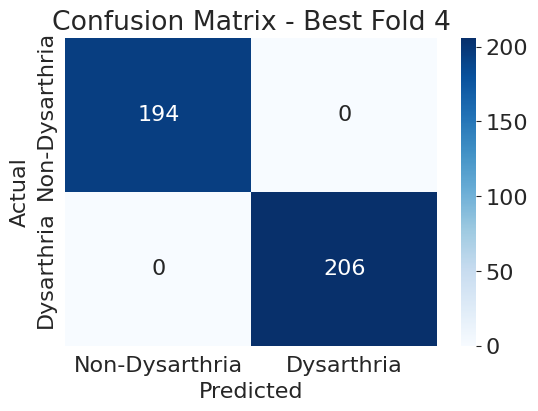

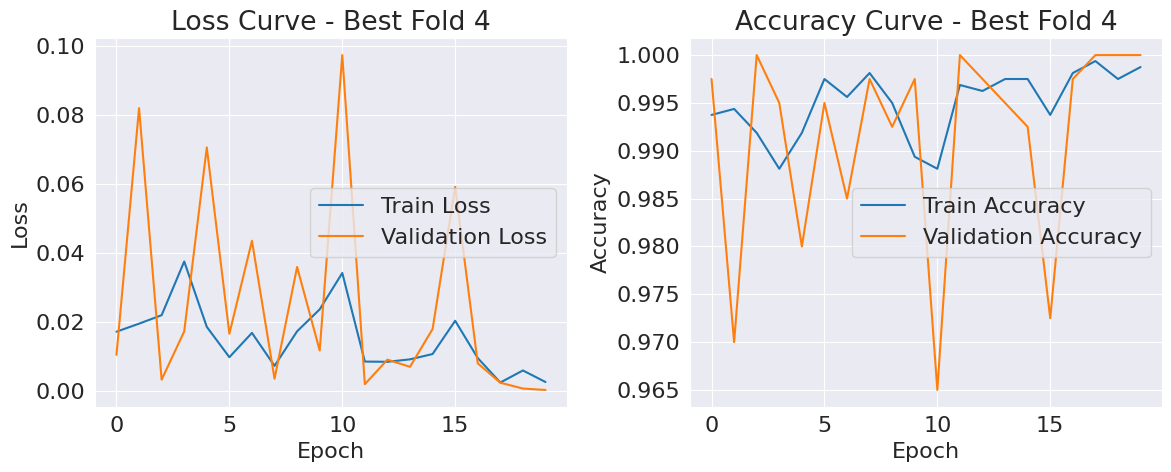


=== Average Across Folds ===
Avg Accuracy:  0.9805
Std Accuracy:  0.0227
Avg Precision: 0.9837
Std Precision: 0.0226
Avg Recall:    0.9767
Std Recall:    0.0242
Avg F1-Score:  0.9802
Std F1-Score:  0.0229


In [ ]:
metrics = train_and_evaluate_with_cv(
    model_name=model,
    X=padded_features,
    y=labels,
    n_splits=5,
    epochs=20,
    batch_size=32
)

# **RNN Only Model**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Masking
import pandas as pd

# Example parameters
input_dim = 128  # Number of MFCC coefficients
rnn_units = 256   # Number of units in the RNN layer
output_dim = 1   # Output dimension for binary classification

# Function to pad sequences to the same length
def pad_sequences(features):
    max_length = 10
    padded_features = tf.keras.preprocessing.sequence.pad_sequences(features, maxlen=max_length, padding='post', dtype='float32')
    return padded_features, max_length


labels = dataf['class'].values

# Pad the sequences
padded_features, max_length = pad_sequences(features)

# Build the RNN model
model = Sequential()
model.add(Masking(mask_value=0.0, input_shape=(max_length, input_dim)))
model.add(SimpleRNN(rnn_units, activation='tanh',dropout=0.2, recurrent_dropout=0.2,))
model.add(Dense(output_dim, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
X[0][0].shape

(9, 128)

In [ ]:
# Train the model with simple RNN
model.fit(padded_features, y, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.6044 - loss: 0.6714 - val_accuracy: 0.7850 - val_loss: 0.5695
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6501 - loss: 0.6198 - val_accuracy: 0.5175 - val_loss: 0.7716
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6996 - loss: 0.5765 - val_accuracy: 0.6600 - val_loss: 0.6745
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7265 - loss: 0.5398 - val_accuracy: 0.7375 - val_loss: 0.5595
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7570 - loss: 0.5033 - val_accuracy: 0.7550 - val_loss: 0.5535
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7561 - loss: 0.4845 - val_accuracy: 0.7450 - val_loss: 0.5860
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7879 - loss: 0.4623 - val_accuracy: 0.6875 - val_loss: 0.6371
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7864 - loss: 0.4621 - val_accuracy: 0.8600 - v


=== Fold 1 ===
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Accuracy:  0.8675
Precision: 0.9290
Recall:    0.7929
F1-Score:  0.8556

=== Fold 2 ===
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Accuracy:  0.9275
Precision: 0.9885
Recall:    0.8643
F1-Score:  0.9223

=== Fold 3 ===
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Accuracy:  0.9350
Precision: 0.9278
Recall:    0.9375
F1-Score:  0.9326

=== Fold 4 ===
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Accuracy:  0.9150
Precision: 0.9216
Recall:    0.9126
F1-Score:  0.9171

=== Fold 5 ===
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy:  0.9298
Precision: 0.9889
Recall:    0.8725
F1-Score:  0.9271


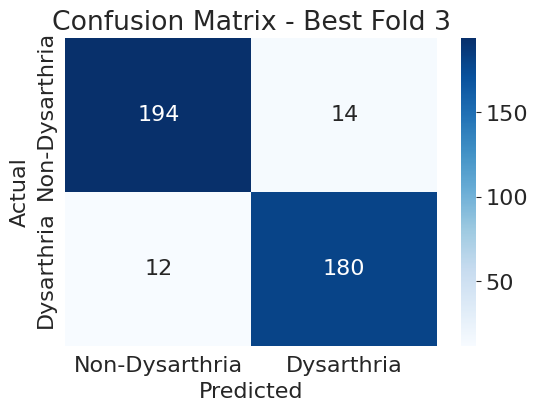

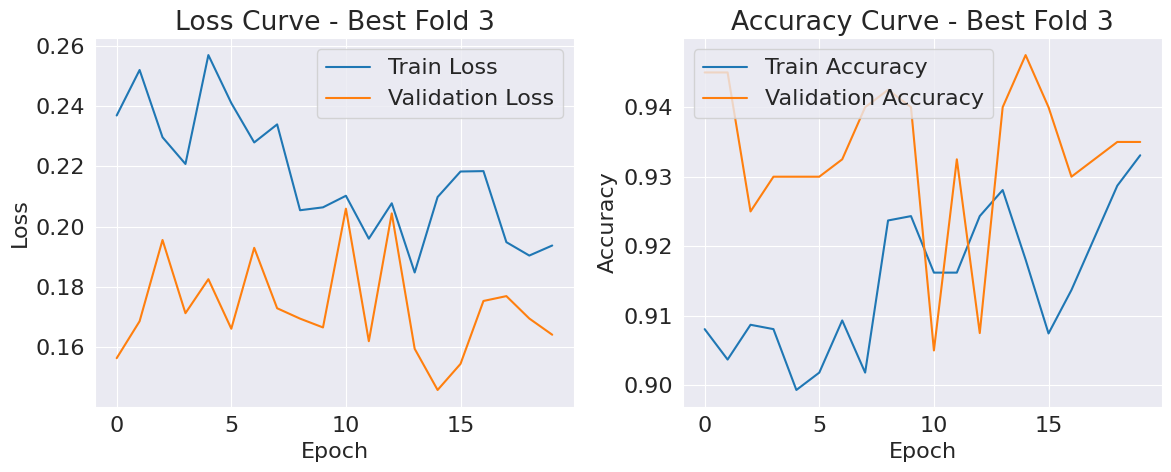


=== Average Across Folds ===
Avg Accuracy:  0.9150
Std Accuracy:  0.0246
Avg Precision: 0.9512
Std Precision: 0.0308
Avg Recall:    0.8760
Std Recall:    0.0493
Avg F1-Score:  0.9109
Std F1-Score:  0.0281


In [ ]:
metrics = train_and_evaluate_with_cv(
    model_name=model,
    X=padded_features,
    y=labels,
    n_splits=5,
    epochs=20,
    batch_size=32
)

# **LSTM Only Model**

In [ ]:
from tensorflow.keras.layers import LSTM

# Build the LSTM model_lstm
model_lstm = Sequential()
model_lstm.add(Masking(mask_value=0.0, input_shape=(max_length, input_dim)))
model_lstm.add(LSTM(rnn_units, activation='tanh', dropout=0.2, recurrent_dropout=0.2, return_sequences=False))

model_lstm.add(Dense(output_dim, activation='sigmoid'))

# Compile the model_lstm
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model_lstm
# model_lstm.fit(padded_features, labels, epochs=20, batch_size=32, validation_split=0.2)



=== Fold 1 ===
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
Accuracy:  0.9050
Precision: 0.9706
Recall:    0.8333
F1-Score:  0.8967

=== Fold 2 ===
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Accuracy:  0.9375
Precision: 1.0000
Recall:    0.8744
F1-Score:  0.9330

=== Fold 3 ===
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy:  0.9900
Precision: 0.9947
Recall:    0.9844
F1-Score:  0.9895

=== Fold 4 ===
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Accuracy:  0.9750
Precision: 1.0000
Recall:    0.9515
F1-Score:  0.9751

=== Fold 5 ===
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Accuracy:  0.9975
Precision: 1.0000
Recall:    0.9951
F1-Score:  0.9975


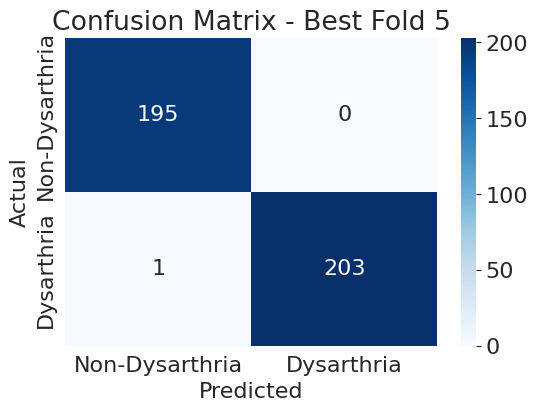

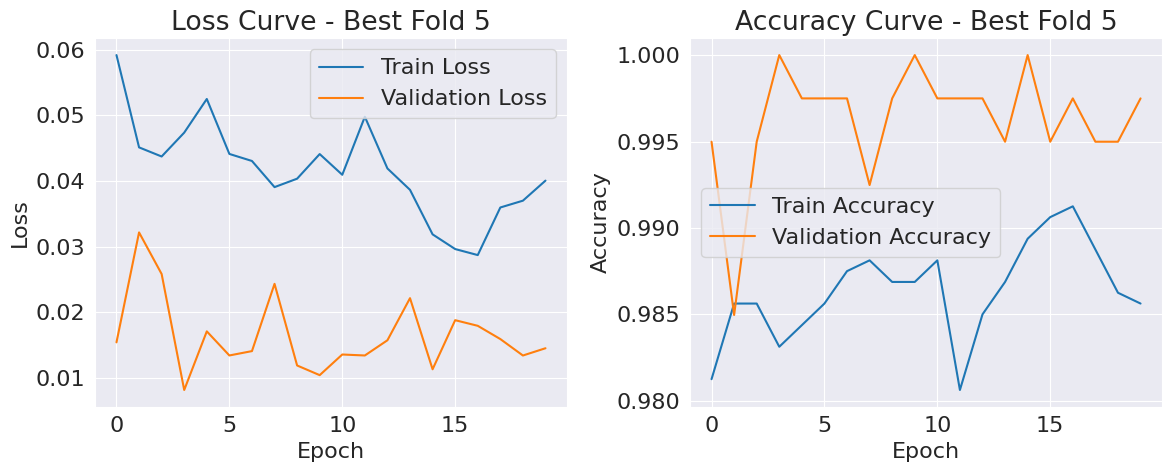


=== Average Across Folds ===
Avg Accuracy:  0.9610
Std Accuracy:  0.0348
Avg Precision: 0.9931
Std Precision: 0.0114
Avg Recall:    0.9277
Std Recall:    0.0634
Avg F1-Score:  0.9584
Std F1-Score:  0.0380


In [ ]:
metrics = train_and_evaluate_with_cv(
    model_name=model_lstm,
    X=padded_features,
    y=labels,
    n_splits=5,
    epochs=20,
    batch_size=32
)

# **Only GRU Model**

In [ ]:
from tensorflow.keras.layers import GRU

# Build the GRU model_gru
model_gru = Sequential()
model_gru.add(Masking(mask_value=0.0, input_shape=(max_length, input_dim)))
model_gru.add(GRU(rnn_units, activation='tanh', return_sequences=False))
model_gru.add(Dense(output_dim, activation='sigmoid'))

# Compile the model_gru
model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model_gru
model_gru.fit(padded_features, labels, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.6478 - loss: 0.6543 - val_accuracy: 0.6750 - val_loss: 0.6194
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.8604 - loss: 0.3862 - val_accuracy: 0.6800 - val_loss: 0.6357
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9232 - loss: 0.2525 - val_accuracy: 0.8750 - val_loss: 0.3990
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9555 - loss: 0.1781 - val_accuracy: 0.8375 - val_loss: 0.4615
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9552 - loss: 0.1419 - val_accuracy: 0.7725 - val_loss: 0.5693
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.9833 - loss: 0.0923 - val_accuracy: 0.7400 - val_loss: 0.6354
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9858 - loss: 0.0649 - val_accuracy: 0.7325 - val_loss: 0.6496
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9859 - loss: 0.0621 - val_accuracy: 0.8050 - v


=== Fold 1 ===
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Accuracy:  0.9800
Precision: 0.9897
Recall:    0.9697
F1-Score:  0.9796

=== Fold 2 ===
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000

=== Fold 3 ===
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000

=== Fold 4 ===
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000

=== Fold 5 ===
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000


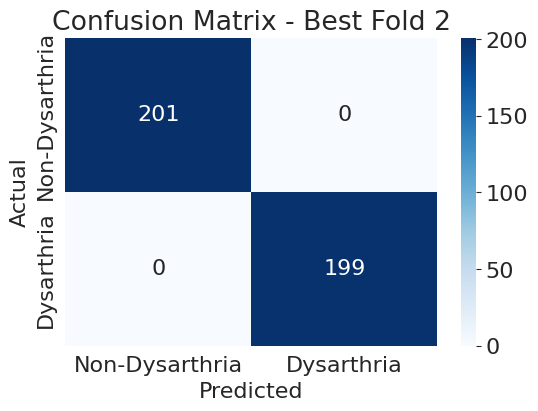

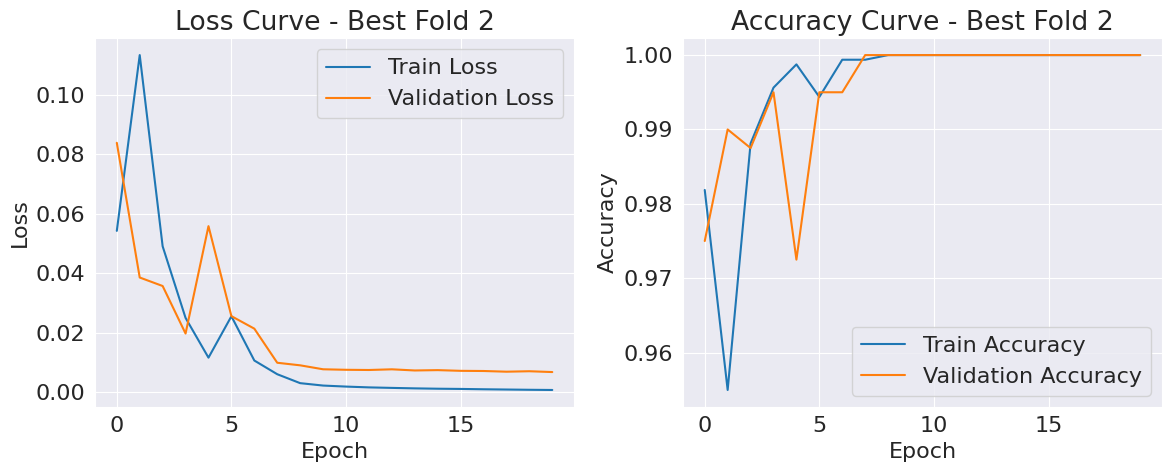


=== Average Across Folds ===
Avg Accuracy:  0.9960
Std Accuracy:  0.0080
Avg Precision: 0.9979
Std Precision: 0.0041
Avg Recall:    0.9939
Std Recall:    0.0121
Avg F1-Score:  0.9959
Std F1-Score:  0.0082


In [ ]:
metrics = train_and_evaluate_with_cv(
    model_name=model_gru,
    X=padded_features,
    y=labels,
    n_splits=5,
    epochs=20,
    batch_size=32
)

# **Only CNN Model**

In [ ]:
import numpy as np
import pandas as pd
import librosa
from tqdm import tqdm

def feature_extraction(df, n_mfcc=128):
    features = []
    labels = []

    for i, record in tqdm(df.iterrows(), total=df.shape[0]):
        try:
            x, sr = librosa.load(record['filename'])

            # Extract MFCC features for the entire audio file
            mfccs = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=n_mfcc)

            # Transpose to make each column a feature vector in sequence
            mfccs = mfccs.T

            # Append the MFCC sequence and the corresponding label
            features.append(mfccs)
            labels.append(record['is_dysarthria'])
        except EOFError:
            pass

    # Create a DataFrame with MFCC features and labels
    dataf = pd.DataFrame({'features': features, 'class': labels})
    return dataf

# Example usage:
data_cnn = feature_extraction(data)
features = dataf['features'].tolist()

data_cnn.loc[dataf['class']=='non_dysarthria','class'] = 0.0
data_cnn.loc[dataf['class']=='dysarthria','class'] = 1.0
data_cnn['class'] = dataf['class'].astype(float)

X = data_cnn.iloc[:,:-1].values
y = data_cnn.iloc[:,-1]


100%|██████████| 2000/2000 [01:03<00:00, 31.52it/s]


In [ ]:
data_cnn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   features  1999 non-null   object 
 1   class     1999 non-null   float64
dtypes: float64(1), object(1)
memory usage: 31.4+ KB


In [ ]:
type(data_cnn.iloc[3]['features'])

numpy.ndarray

# **MISC**

In [ ]:
import numpy as np
import tensorflow as tf

# Pad or truncate the feature arrays to a fixed length
def pad_or_truncate(features, max_length):
    padded_features = []
    for feature in features:
        if len(feature) > max_length:
            padded = feature[:max_length]  # Truncate
        else:
            padded = np.pad(feature, ((0, max_length - len(feature)), (0, 0)), mode='constant')  # Pad
        padded_features.append(padded)
    return np.array(padded_features)

# Set a fixed max_length based on your dataset
max_length = max(data_cnn['features'].apply(lambda x: len(x)))  # Or a fixed value you prefer
input_dim = data_cnn['features'][0].shape[1]  # Number of MFCC coefficients (columns in features)

# Prepare the data
X = pad_or_truncate(data_cnn['features'].tolist(), max_length)
y = np.array(data_cnn['class'])

# Split into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, GRU, Dense, Dropout

# Build the model
model = Sequential()

# CNN Layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(max_length, input_dim)))
model.add(MaxPooling1D(pool_size=2))

# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(64, return_sequences=True, activation='tanh')))

# GRU Layer
model.add(GRU(64, return_sequences=False, activation='tanh'))

# Fully Connected Layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))  # Regularization
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")


Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.4957 - loss: 0.6933 - val_accuracy: 0.5125 - val_loss: 0.6930
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.5090 - loss: 0.6929 - val_accuracy: 0.4875 - val_loss: 0.6932
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.4810 - loss: 0.6927 - val_accuracy: 0.4875 - val_loss: 0.6943
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.5029 - loss: 0.6935 - val_accuracy: 0.4875 - val_loss: 0.6946
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.5075 - loss: 0.6908 - val_accuracy: 0.5125 - val_loss: 0.6929
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.4917 - loss: 0.6928 - val_accuracy: 0.4875 - val_loss: 0.6933
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.5019 - loss: 0.6922 - val_accuracy: 0.4875 - val_loss: 0.6934
Epoch 8/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.4629 - loss: 0.6944 - val_accuracy: 0.4875 - val_loss: